In [0]:
table_name = 'default.data_rating'
df = spark.table('default.data_rating')

In [0]:
# totsl number of entries 1.3 mil
total_entries = df.count()
print("Total number of entries in the DataFrame:", total_entries)


Total number of entries in the DataFrame: 1369534


In [0]:
# Connect to the first table
table_name_1 = 'default.data_rating'
df_1 = spark.table(table_name_1)

# Get total entries for the first table
total_entries_1 = df_1.count()
print(f"Total number of entries in the DataFrame '{table_name_1}': {total_entries_1}")

# Connect to the second table
table_name_2 = 'default.data'
df_2 = spark.table(table_name_2)

# Get total entries for the second table
total_entries_2 = df_2.count()
print(f"Total number of entries in the DataFrame '{table_name_2}': {total_entries_2}")


Total number of entries in the DataFrame 'default.data_rating': 1369534
Total number of entries in the DataFrame 'default.data': 13002531


In [0]:
# Here we combine both the tables person details and title with ratings and number of votes 

from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split

# Create a Spark session
spark = SparkSession.builder.appName("example").getOrCreate()

# Create DataFrames
df_table1 = df_2
df_table2 = df_1
# Specify the nconst to filter
selected_nconst = "nm0000201"

# Select relevant rows from Table 1
selected_row = df_table1.filter(df_table1.nconst == selected_nconst).select("nconst", "knownForTitles")

# Explode the knownForTitles column to create separate rows for each title
exploded_titles = selected_row.select("nconst", explode(split("knownForTitles", ","))).alias("tconst")

# Join with Table 2 to get ratings
result_df = exploded_titles.join(df_table2, exploded_titles["col"] == df_table2["tconst"], "inner").select("nconst", "col", "averageRating", "numVotes")

result_df.show()


+---------+---------+-------------+--------+
|   nconst|      col|averageRating|numVotes|
+---------+---------+-------------+--------+
|nm0000201|tt0106226|          7.2|   65637|
|nm0000201|tt0427327|          6.7|  136572|
|nm0000201|tt0161081|          6.6|  133547|
|nm0000201|tt0117247|          6.5|   47942|
+---------+---------+-------------+--------+



In [0]:
# Count the number of entries for each unique average rating
rating_counts = df.groupBy('averageRating').count()
rating_counts.show()


+-------------+-----+
|averageRating|count|
+-------------+-----+
|          2.4| 1111|
|          8.0|43571|
|          5.4|16103|
|          7.0|47228|
|          3.5| 2744|
|          6.1|23506|
|          9.5| 3940|
|          7.7|42668|
|          6.6|36302|
|          8.7|16521|
|          2.9| 1358|
|          3.7| 3281|
|          4.5| 6473|
|          5.7|18041|
|          1.4|  404|
|          6.7|33640|
|          1.7|  486|
|          7.4|49144|
|          2.3|  896|
|          6.5|30729|
+-------------+-----+
only showing top 20 rows



In [0]:
# top 3 movies with the highest average rating
from pyspark.sql.functions import desc, avg, rank, sum, col, mean, floor
from pyspark.sql.window import Window
windowSpec = Window.orderBy(desc("averageRating"))
top_movies = df.withColumn("rank", rank().over(windowSpec)).filter("rank <= 3").drop("rank")
top_movies.show()


+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0015927|         10.0|      16|
|tt0058271|         10.0|      12|
|tt0058559|         10.0|      14|
|tt0065800|         10.0|      17|
|tt0127236|         10.0|      23|
|tt0160316|         10.0|      14|
|tt0183268|         10.0|      13|
|tt0184926|         10.0|      12|
|tt0193147|         10.0|       6|
|tt0258117|         10.0|      12|
|tt0270927|         10.0|      11|
|tt0281732|         10.0|      11|
|tt0285180|         10.0|      10|
|tt0300220|         10.0|      10|
|tt0300386|         10.0|      10|
|tt0301052|         10.0|      15|
|tt0302703|         10.0|       8|
|tt0304000|         10.0|      10|
|tt0322543|         10.0|      10|
|tt0323536|         10.0|      10|
+---------+-------------+--------+
only showing top 20 rows



In [0]:
# movies with a rating above the average rating and more votes than the average number of votes
avg_rating = df.select(mean("averageRating")).collect()[0][0]
avg_votes = df.select(mean("numVotes")).collect()[0][0]

high_rated_high_votes = df.filter((col("averageRating") > avg_rating) & (col("numVotes") > avg_votes))
high_rated_high_votes.show()


+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000012|          7.4|   12535|
|tt0000014|          7.1|    5664|
|tt0000211|          7.4|    4545|
|tt0000359|          7.1|    3077|
|tt0000417|          8.2|   54089|
|tt0000439|          7.3|   20503|
|tt0000465|          7.3|    1732|
|tt0000499|          7.5|    3858|
|tt0001527|          7.7|    3132|
|tt0001737|          7.1|    1801|
|tt0002130|          7.0|    3293|
|tt0003014|          7.0|    1376|
|tt0003424|          7.4|    2054|
|tt0003740|          7.1|    3836|
|tt0004008|          7.1|    3573|
|tt0006206|          7.3|    5285|
|tt0006864|          7.7|   16446|
|tt0006886|          7.2|    1104|
|tt0007145|          7.0|    3529|
|tt0007162|          7.0|    3597|
+---------+-------------+--------+
only showing top 20 rows



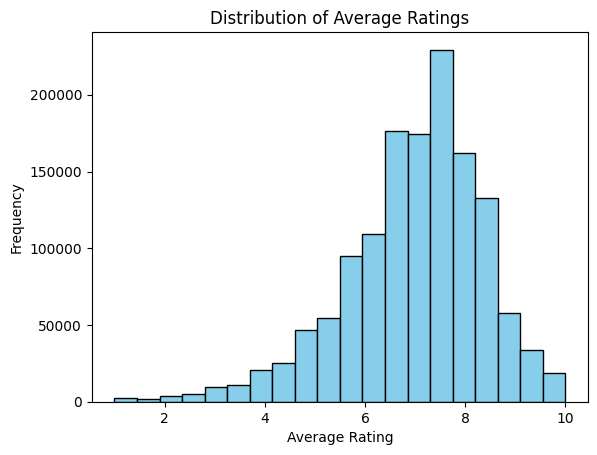

In [0]:
# Average rating vs number of votes
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your PySpark DataFrame
pandas_df = df.toPandas()

# Example: Plotting a histogram of average ratings
plt.hist(pandas_df['averageRating'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()


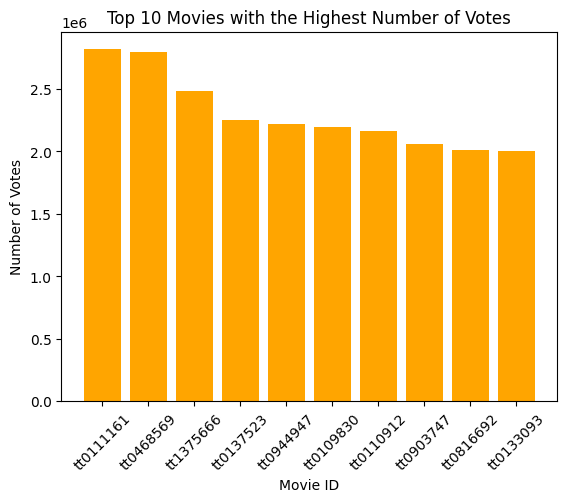

In [0]:
# Bar chart of the top 10 movies with the highest number of votes
top_movies_votes = pandas_df.sort_values(by='numVotes', ascending=False).head(10)
plt.bar(top_movies_votes['tconst'], top_movies_votes['numVotes'], color='orange')
plt.title('Top 10 Movies with the Highest Number of Votes')
plt.xlabel('Movie ID')
plt.ylabel('Number of Votes')
plt.xticks(rotation=45)
plt.show()


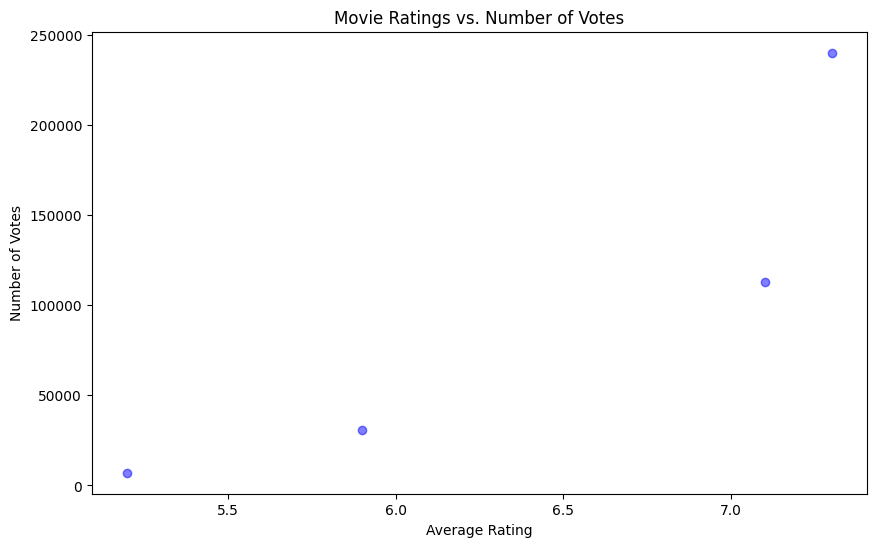

In [0]:

# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_result_df = result_df.toPandas()

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(pandas_result_df['averageRating'], pandas_result_df['numVotes'], color='blue', alpha=0.5)
plt.title('Movie Ratings vs. Number of Votes')
plt.xlabel('Average Rating')
plt.ylabel('Number of Votes')
plt.show()


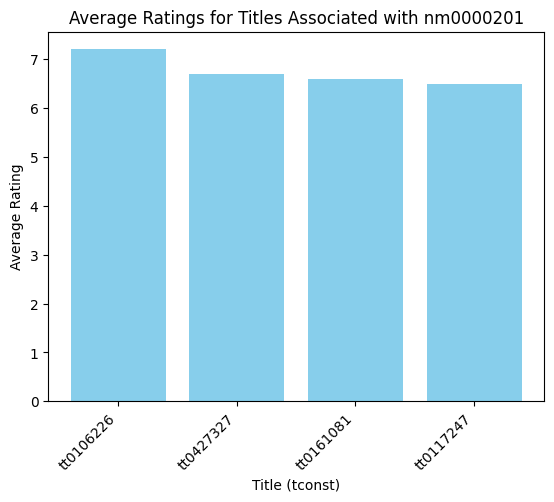

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Collect the PySpark DataFrame to a Pandas DataFrame
result_pandas_df = result_df.toPandas()

# Plotting a bar chart
plt.bar(result_pandas_df['col'], result_pandas_df['averageRating'], color='skyblue')
plt.title(f'Average Ratings for Titles Associated with {selected_nconst}')
plt.xlabel('Title (tconst)')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.show()
